In [1]:
#install.packages(c("tidymodels"))
#install.packages("kknn")

library(tidyverse)
library(repr)
library(tidymodels)
library(themis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## DSCI 100 Group Project:
Group members(UBC student number): Tahsan Samin (15680358), Charlene Tam (90063090), Tania Ghassemi, Octave Moha

### Title: Predicting player subscription status to a game related newsletter using the number of hours played and the age of the players

### Introduction
### Data Source
The dataset that will be explored today concerns itself with how people play video games. The data was collected by [a research group at UBC](https://plai.cs.ubc.ca/) from [their self-built MineCraft server](https://plaicraft.ai/).

In [2]:
players <- read_csv("https://raw.githubusercontent.com/tahsansamin/group-project-41-dsci/refs/heads/main/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Variable Summary


In [3]:
# please run the code below to see a summary of statistics
summary(players)

mean_table <- players |>
    summarize(
        "Played Hours" = round(mean(played_hours, na.rm = TRUE), 2),
        "Age" = round(mean(Age, na.rm = TRUE), 2)
    ) |>
    pivot_longer(
        cols = everything(),
        names_to = "Variable",
        values_to = "Mean"
    )
mean_table

  experience        subscribe       hashedEmail         played_hours    
 Length:196         Mode :logical   Length:196         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :144       Mode  :character   Median :  0.100  
                                                       Mean   :  5.846  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
                                                                        
     name              gender               Age       
 Length:196         Length:196         Min.   : 9.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :21.14  
                                       3rd Qu.:22.75  
                                       Max.   :58.00  
                               

Variable,Mean
<chr>,<dbl>
Played Hours,5.85
Age,21.14


According to the `summary()` output above, the data set `players.csv`contains **196 observations**, where each observation represents a unique player, and **7 variables**:
- **Character**: `experience`, `hashedEmail`, `name`, `gender`
- **Numeric**: `played_hours`, `Age`
- **Logical**: `subscribe`

### Visible Issues
- The `Age` variable is missing 2 out of 196 values, which will need to be handled with code such as `na.rm = TRUE`, removing the observations with the missing values altogether or imputing the missing values before modeling.
- All `character` variables will need to be converted to be used correctly in a predictive model.

### Invisible Issues
- We only have data on 196 players who found and chose to join this research. This does not necessarily generalize data about *all* players. 
- The `experience`, `gender`, and `Age` variables were self-reported, which could lead to potential noise.

### Broad question
Question 1: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"

### Specific Question
##### "How can a player's `played_hours`and `Age` be used to predict their likelihood of subscribing (true or false for `subscribe`) to the newsletter?" 

The `played_hours`and `Age` variables are chosen because logically it is expected that individuals who play for longer hours are more likely to subscribe to a game-related newsletter. Also, younger individuals are more likely to spend more hours playing the video game than older individuals and are subsequently more likely to subscribe to the newsletter. 

Most importantly, `played_hours`and `Age` are numerical values where we can directly apply `k-NN classification` on prediction, while `experience` and `gender` have to be converted before predicting. For the rest of the variables, including `hashedEmail` and `name`, are unique to each player, which means they would not be a possible predictor option.


### Data Plan
The `players.csv` dataset will be a perfect fit for answering our question, as it contains all the required variables.

To apply a `k-NN` model, the data must be wrangled in the following ways:

1. Drop the 2 missing Age values.
2. Select only the `played_hours`, `Age` and `subscribe` variables.
3. Standardize all numeric predictors so that they are on a common scale.

### Methods and Results
For our project `k-NN classification` will be used because our selected player variables (`Age` and `played_hours`) are numerical and our target variable (`subscribe`) is categorical. From `players.csv`, the rows with `NA` values will be removed and only `Age`, `played_hours`, and `subscribe` will be selected. 

The data will be split into **75% training data** and **25% testing data**. **5-fold cross-validation** with a range of Ks will be used to select the model based on the highest cross-validation accuracy. We will use 5 folds because of computational efficiency.

#### Loading and wrangling the dataset into a tidy format
The dataset already satisfies all criteria for being tidy. We decided to drop the two observations with `NA` values because they are such a small number that it is unlikely to cause loss of valuable information. The two `NA` observations are `NA` in the age column. Looking at their reading for the number of hours played (0.1 hours and 0.2 hours), the readings do not appear to be extreme cases, further proving that dropping `NA` values would not cause loss of valuable data. We will also change the subscription status into the factor data type to make it suitable for `k-NN classification`.

In [4]:
is_na <- sum(is.na(players))
is_na

[1] 2

In [5]:
narows <- players[!complete.cases(players),]
narows

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Regular,TRUE,7d71c49cbbce8dcf0276b2bfecfa2d16f22cb31a4024556d6085884298f2ee8d,0.1,Devin,Two-Spirited,NA
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [6]:
players <- drop_na(players)
players <- players |> mutate(subscribe = as_factor(subscribe))

#### Summary of the players dataset
We will now perform a statistical summary of the numerical variables in the players dataset. Right away it is clear that we may be dealing with a few outliers for the number of hours played variable because it has such a large range from **0 hours** to **223.10 hours** but such a small `mean` of **5.85 hours**. This is something that should be kept in mind. 

In [7]:
summary_stats_players <- players |> 
                summarise(min_Age = min(Age, na.rm = TRUE),max_Age = max(Age, na.rm = TRUE),mean_age = mean(Age, na.rm = TRUE), min_played_hours = min(played_hours),max_played_hours = max(played_hours), 
                         , mean_played_hours = mean(played_hours, na.rm = TRUE))

#### Players.csv

| Variable | Minimum | Maximum | Mean |
| -------- | ------- | -------- | -----|
| Age | 9.00 | 58.00 | 21.14 |
| played_hours | 0.00 | 223.10 | 5.85 |

#### Visualization of the players dataset
Below is a scatter plot of the number of hours played versus the age of the player. We log scaled the y axis to make the data points more visible. As was suspected before, there are a few outliers for the number of hours played. For now we will do the KNN classification algorithm with these outliers to see if they actually have a negative impact on our results. Furthermore, there seems to be a class imbalance with more observations for true subscription statuses. For now we will attempt the KNN classification algorithm without accounting for this to try and see if it actually negatively impacts our results.

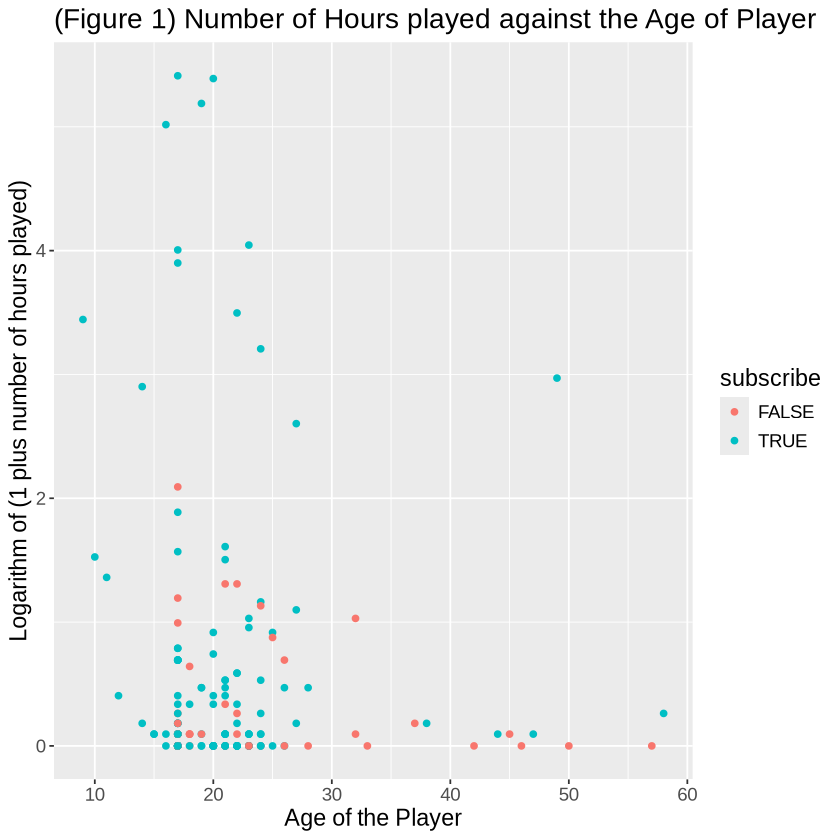

In [8]:
figure_1 <- players |>
            ggplot(aes(x = Age, y= log1p(played_hours), color = subscribe)) +
            geom_point() +
            labs(x = "Age of the Player", y = "Logarithm of (1 plus number of hours played)", title = "(Figure 1) Number of Hours played against the Age of Player") +
            theme(text = element_text(size = 14)) 
#log1p was added after discussion with a TA on how to make both variables on comparable scales.
#standardising and centering the variables did not work in making the variables comparable so log1p was suggested by the TA
figure_1

#### Data analysis
##### Splitting the dataset into training and testing splits

In [9]:
set.seed(9999) 
game_split <- initial_split(players, prop = 0.75, strata = subscribe)  
game_train <- training(game_split)
game_test <- testing(game_split)
head(game_train)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,FALSE,2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53,0.0,Quinlan,Male,22
Amateur,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,Female,17
Veteran,FALSE,f8acd26a5e452b682b9f8b20108caef1ee2e745efe08e95806980bd2388a3fea,0.0,Finn,Male,23
Veteran,FALSE,951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd,0.1,Vivienne,Male,18


Next we will create the recipe to be applied on our dataset for KNN classification.

In [2]:
game_recipe <- recipe(subscribe ~ played_hours + Age , data = game_train) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

ERROR: Error in eval(expr, envir, enclos): object 'game_train' not found


Next we will create our model specification and prepare the data for cross validation. A range of values from 1 to 15 was selected for tuning the number of neighbors. Conventionally a range of K values from 1 up to the value for the square root of the dataset size is used. Our dataset size 196 and the square root of it is 14, so we decided to use a range of Ks from 1 to 15. Furthermore, we think that this range is computationally efficient.

In [11]:
set.seed(1234) 
game_vfold <- vfold_cv(game_train, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We will now perform the 5 cross fold validation.

In [12]:
set.seed(2456)
knn_results <- workflow() |>
      add_recipe(game_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = game_vfold, grid = k_vals) |>
      collect_metrics()
head(knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5593596,5,0.03233644,Preprocessor1_Model01
1,roc_auc,binary,0.5781926,5,0.03619044,Preprocessor1_Model01
2,accuracy,binary,0.5455665,5,0.02398160,Preprocessor1_Model02
2,roc_auc,binary,0.6016659,5,0.02662140,Preprocessor1_Model02
3,accuracy,binary,0.5929064,5,0.01750648,Preprocessor1_Model03
3,roc_auc,binary,0.5906347,5,0.03608753,Preprocessor1_Model03


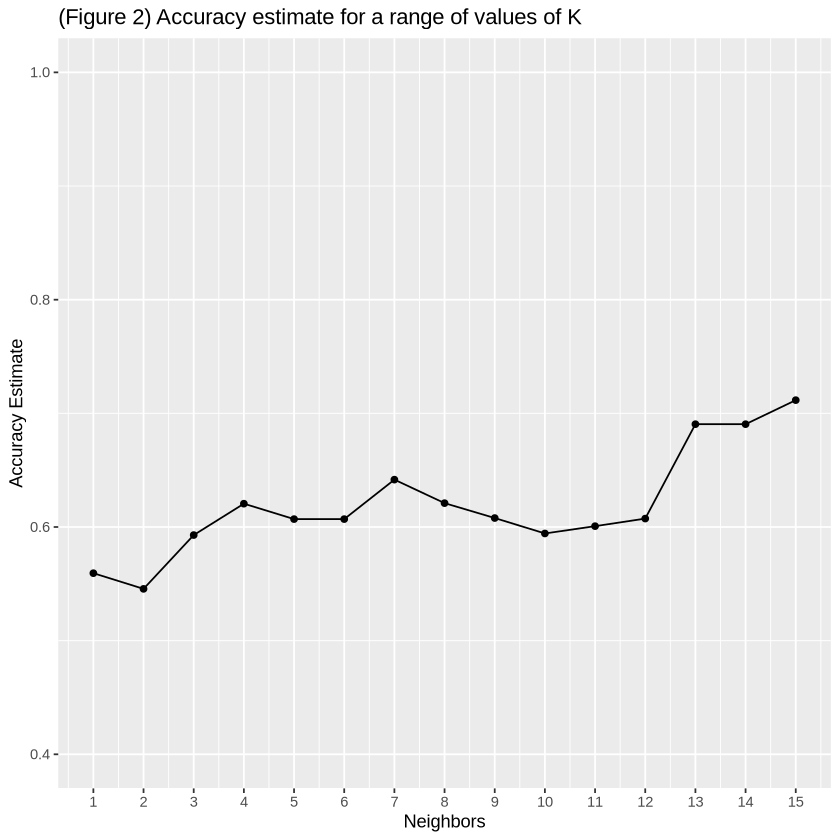

In [13]:
accuracies <- knn_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "(Figure 2) Accuracy estimate for a range of values of K") +
      scale_x_continuous(breaks = seq(0, 15, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

A K value of 15 neighbors seems to give the highest accuracy with a value just above 70%.
We will next re train a new KNN classification model with K = 15 and use that to perform predictions on the testing dataset to evaluate our model performance.

In [14]:
set.seed(9999) 
new_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
       set_engine("kknn") |>
       set_mode("classification")

game_fit <- workflow() |>
             add_recipe(game_recipe) |>
             add_model(new_spec) |>
            fit(data = game_train)
game_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(15,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2689655
Best kernel: rectangular
Best k: 15

In [15]:
set.seed(9999) 


game_predictions <- predict(game_fit, game_test) |>
                        bind_cols(game_test)

game_metrics <- game_predictions |> metrics(truth = subscribe, estimate = .pred_class)

game_conf_mat <- game_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
game_metrics
game_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6530612
kap,binary,-0.1426612


          Truth
Prediction FALSE TRUE
     FALSE     0    4
     TRUE     13   32

The model appears to be performing well with an accuracy performance of 65% ,but this is not enough. It looks like the issue of class imbalance is really affecting our model because it did not predict any of the false subscription statuses as actually being false. Let's try this again by oversampling the observations with false subscription statuses. We will only upsample on the training data because we still need the original test dataset to evaluate whether our upsampling had any positive effects.

In [25]:
new_game_recipe <- recipe(subscribe ~ played_hours + Age, data = game_train) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
  prep()

game_train <- bake(new_game_recipe, game_train)

Since upsampling changes the structure of our dataset, we will need to perform cross fold validation again. For cross validation we will increase the range of values of K because it looks like we are achieving higher accuracy for higher values of K.

In [17]:
set.seed(1234) 
new_game_vfold <- vfold_cv(game_train, v = 5, strata = subscribe)
new_knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

In [18]:
set.seed(2456)
new_knn_results <- workflow() |>
      add_recipe(game_recipe) |>
      add_model(new_knn_tune) |>
      tune_grid(resamples = new_game_vfold, grid = tibble(neighbors = seq(from = 1, to = 25, by = 1))) |>
      collect_metrics()
head(new_knn_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7110390,5,0.03290114,Preprocessor1_Model01
1,roc_auc,binary,0.7110390,5,0.03290114,Preprocessor1_Model01
2,accuracy,binary,0.7062771,5,0.03479669,Preprocessor1_Model02
2,roc_auc,binary,0.7180534,5,0.03767807,Preprocessor1_Model02
3,accuracy,binary,0.6541126,5,0.04393673,Preprocessor1_Model03
3,roc_auc,binary,0.6928028,5,0.04441316,Preprocessor1_Model03


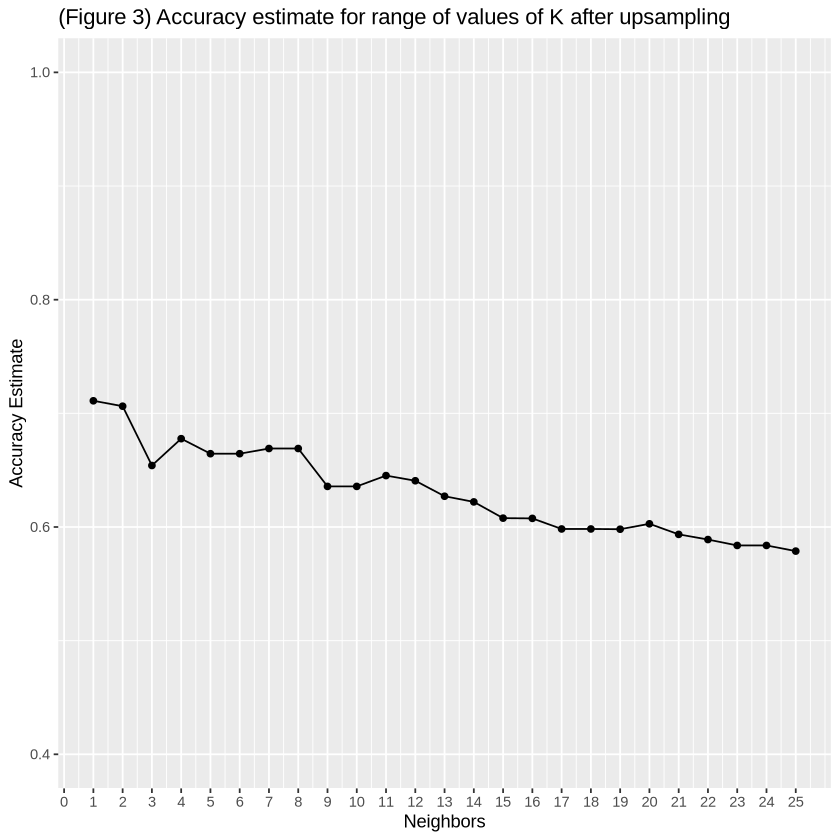

In [19]:
new_accuracies <- new_knn_results |> 
      filter(.metric == "accuracy")

new_accuracy_versus_k <- ggplot(new_accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "(Figure 3) Accuracy estimate for range of values of K after upsampling") +
      scale_x_continuous(breaks = seq(0, 25, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

new_accuracy_versus_k

It looks like the highest performance comes from **K = 2**, excluding the performance for **K=1**.

In [26]:
set.seed(9999) 
newer_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 4) |>
       set_engine("kknn") |>
       set_mode("classification")

new_game_fit <- workflow() |>
             add_recipe(game_recipe) |>
             add_model(newer_spec) |>
            fit(data = game_train)
new_game_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(4,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3349057
Best kernel: rectangular
Best k: 4

In [27]:
set.seed(9999) 


new_game_predictions <- predict(new_game_fit, game_test) |>
                        bind_cols(game_test)

new_game_metrics <- new_game_predictions |> metrics(truth = subscribe, estimate = .pred_class)

new_game_conf_mat <- new_game_predictions |>
                        conf_mat(truth = subscribe, estimate = .pred_class) 
new_game_metrics
new_game_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4081633
kap,binary,-0.1092896


          Truth
Prediction FALSE TRUE
     FALSE     6   22
     TRUE      7   14

Taking the `TRUE` label as the positive target, we can calculate the precision, recall and accuracy of our model. The precision is around 68%. The recall is 

creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
performs the data analysis
creates a visualization of the analysis 

- plans
- Not best method(KNN deals very poorly with imbalance)
- Data not enough more data to train it
- Classes imbalanced
- Model too simple
- overfit/underfit

### Discussion

Discussion:
summarize what you found
- We found that this data could not predict. not learning meaningfully.
- model is worse than random guessing 
- add more data.
- try more powerful model like random forest, logistic regression, svm, dec tree
- add class weightages or undersample. 
discuss whether this is what you expected to find
- NO. We expected higher accuracy. Positive cohensomething. More than 60% accuracy at minimum. reasons: using supervised learning.  
discuss what impact could such findings have
- increase advertising to specific age groups or demographics.
- increased user engagement. e.g high user players would like more frequent updates.
- 
discuss what future questions could this lead to




### Summary of observation
We have concluded that `played_hours` and `Age` are not enough to predict the subscription status of an individual. This is because the accuracy of the result of our `k-NN` prediction was even worse than pure guessing, with a rate of around 40%. This low accuracy could be due to **the poor original data split**, **the variables we chose being poor predictors**, or **a poor data set**. 

We have tried to improve the accuracy by **upsampling** the data; however, it has gotten even worse. This could be due to the fact that our method for upsampling was not the most ideal, which was limited by how much the course had taught so far. In the future, better upsampling methods would be chosen. What the upsampling we did in this case was purely increasing the number of observations by repeating the same observations over and over. A better way to upsample the dataset would be to generate new observations to give valuable new data.



### References(optional)